# Solar Panel Classification

## Project Overview
This notebook demonstrates an end-to-end pipeline for classifying solar panel images into 6 categories:
1. Bird-drop
2. Clean
3. Dusty
4. Electrical-damage
5. Physical-Damage
6. Snow-Covered

We aim to achieve >85% accuracy using **Transfer Learning with EfficientNetB0** and **Hyperparameter Optimization (HPO)** using Keras Tuner.

## Workflow
1. **Data Loading & Preprocessing**: Loading images, handling class imbalance (if any), and applying augmentation.
2. **Phase 1: Base Model Training**: Using a frozen EfficientNetB0 backbone with a tuned classification head.
3. **Phase 2: Fine-Tuning**: Unfreezing top layers to adapt the model specifically to solar panel textures.
4. **Evaluation**: Comparing metrics between the base and fine-tuned models.

In [1]:
# Install Keras Tuner if not already installed
!pip install -q keras-tuner

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix

# Set Random Seed for Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"TensorFlow Version: {tf.__version__}")

2026-01-29 08:42:01.149792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769676121.456135      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769676121.553690      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769676122.340595      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769676122.340643      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769676122.340646      55 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0


## 1. Data Loading

In [3]:
# Constants
DATA_DIR = '/kaggle/input/solar-panel-images/Data'  # Relative path to the dataset folder
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Check if Data directory exists
if not os.path.exists(DATA_DIR):
    print(f"WARNING: Data directory '{DATA_DIR}' not found. Please ensure the dataset is in the correct path.")
else:
    print(f"Data directory found: {DATA_DIR}")

# Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
print(f"\nClass Names: {class_names}")

Data directory found: /kaggle/input/solar-panel-images/Data
Found 885 files belonging to 6 classes.
Using 708 files for training.


I0000 00:00:1769676138.874394      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 885 files belonging to 6 classes.
Using 177 files for validation.

Class Names: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


## 2. Data Visualization

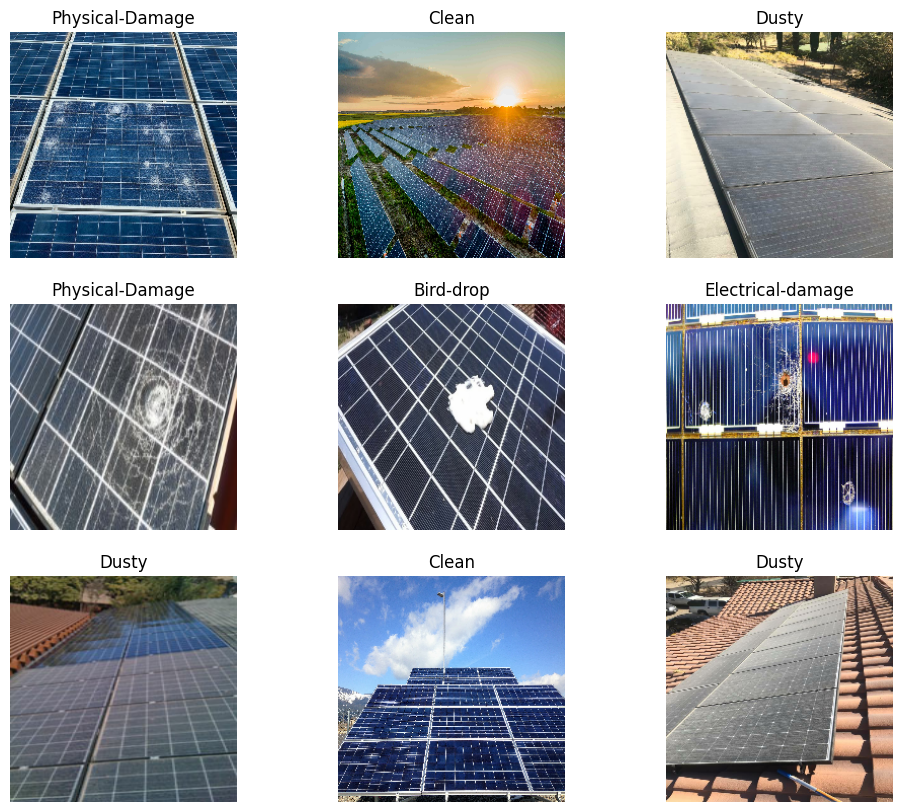

In [4]:
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 3. Data Preprocessing & Augmentation
We use `tf.data.AUTOTUNE` to optimize data loading performance. We also apply augmentation layers to artificially increase the diversity of our training set, which helps prevent overfitting.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation Sequential Model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 4. Phase 1: Base Model (Transfer Learning)
We use **EfficientNetB0** as our base feature extractor. We will keep its weights **frozen** initially and only train the top classification layers.

### Hyperparameter Optimization (HPO)
We use **Keras Tuner** to find the best values for:
- Dropout rate
- Dense layer units
- Learning rate

In [6]:
def build_model(hp):
    # Load EfficientNetB0 Base
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False  # Freeze the base model

    # Inputs
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = data_augmentation(inputs)
    
    # EfficientNet expects 0-255 inputs (it has internal rescaling), 
    # but just to be safe and explicit if we switched models:
    # x = layers.Rescaling(1./255)(x) 
    
    x = base_model(x, training=False) # Important: training=False to keep BatchNorm in inference mode
    x = layers.GlobalAveragePooling2D()(x)
    
    # Tunable dense layer
    hp_units = hp.Int('units', min_value=128, max_value=512, step=64)
    x = layers.Dense(hp_units, activation='relu')(x)
    
    # Tunable dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    x = layers.Dropout(hp_dropout)(x)
    
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    # Tunable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
# Initialize Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='solar_panel_classification'
)

# Run Search
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Starting Hyperparameter Search...")
tuner.search(train_ds, epochs=10, validation_data=val_ds, callbacks=[stop_early])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest Units: {best_hps.get('units')}")
print(f"Best Dropout: {best_hps.get('dropout')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.6440678238868713

Best val_accuracy So Far: 0.8135592937469482
Total elapsed time: 00h 11m 14s

Best Units: 384
Best Dropout: 0.30000000000000004
Best Learning Rate: 0.001


### Training the Best Base Model
**Note:** To preserve the high accuracy achieved during the search, we load the best model directly instead of retraining it from scratch.

In [8]:
# Load the best model directly from the search results (weights included)
base_model = tuner.get_best_models(num_models=1)[0]

# Verify the model is the one we expect
base_model.summary()

print("Loaded best model from tuner. Skipping re-training to preserve weights.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │       491,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,543,785 (17.33 MB)

 Trainable params: 494,214 (1.89 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Loaded best model from tuner. Skipping re-training to preserve weights.


### Evaluate Base Model

In [9]:
loss_base, acc_base = base_model.evaluate(val_ds)
print(f"Base Model Validation Accuracy: {acc_base*100:.2f}%")

# Save Base metrics for comparison
results_comparison = {}
results_comparison['Base Model (Frozen)'] = {'Accuracy': acc_base, 'Loss': loss_base}

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8246 - loss: 0.5901
Base Model Validation Accuracy: 81.36%


## 5. Phase 2: Fine-Tuning
We now unfreeze the top 20 layers of the EfficientNetB0 base model and retrain with a very low learning rate. This allows the model to adapt slightly to the specific features of solar panels.

In [10]:
# Access the EfficientNetB0 layer (index 2 in our Sequential model)
efficient_net = base_model.layers[2]
efficient_net.trainable = True

# Fine-tuning Strategy:
# 1. Unfreeze the top N layers (e.g., top 30).
# 2. CRITICAL: Keep all BatchNormalization layers FROZEN. 
#    Unfreezing BN layers in EfficientNet during fine-tuning often destroys performance
#    because the running mean/variance updates too quickly for the new data.

for layer in efficient_net.layers[:-30]:
    layer.trainable = False

for layer in efficient_net.layers[-30:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# Recompile with a low learning rate (1e-5 is standard for fine-tuning)
base_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print trainable status check
print(f"Base model (EfficientNet) trainable: {efficient_net.trainable}")
print(f"Number of layers in base model: {len(efficient_net.layers)}")
print("Fine-tuning top 30 layers (excluding BatchNormalization)...")

# Train Fine-Tuned Model
history_finetuned = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,     # This is the TOTAL epochs (phase 1 + phase 2 if continuing), but since we reloaded, 
                   # we can just treat this as a fresh 20 epochs for fine-tuning.
    initial_epoch=0, # Reset epoch count since we are starting fine-tuning fresh
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ]
)

Base model (EfficientNet) trainable: True
Number of layers in base model: 238
Fine-tuning top 30 layers (excluding BatchNormalization)...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9289 - loss: 0.2079 - val_accuracy: 0.8023 - val_loss: 0.6624
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9413 - loss: 0.1846 - val_accuracy: 0.7910 - val_loss: 0.6420
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9460 - loss: 0.1714 - val_accuracy: 0.8079 - val_loss: 0.6461
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9464 - loss: 0.1722 - val_accuracy: 0.7853 - val_loss: 0.6538
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9439 - loss: 0.1816 - val_accuracy: 0.7966 - val_loss: 0.6094
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9470 - loss: 0.1679 - val_accuracy: 0.7966 - val_loss: 0.6216
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9305 - loss: 0.1869 - val_accurac

### Evaluate Fine-Tuned Model

In [11]:
loss_ft, acc_ft = base_model.evaluate(val_ds)
print(f"Fine-Tuned Model Validation Accuracy: {acc_ft*100:.2f}%")

results_comparison['Fine-Tuned Model'] = {'Accuracy': acc_ft, 'Loss': loss_ft}

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8218 - loss: 0.6168
Fine-Tuned Model Validation Accuracy: 80.79%


## 6. Comparison & Evaluation

                     Accuracy      Loss
Base Model (Frozen)  0.813559  0.615327
Fine-Tuned Model     0.807910  0.646102


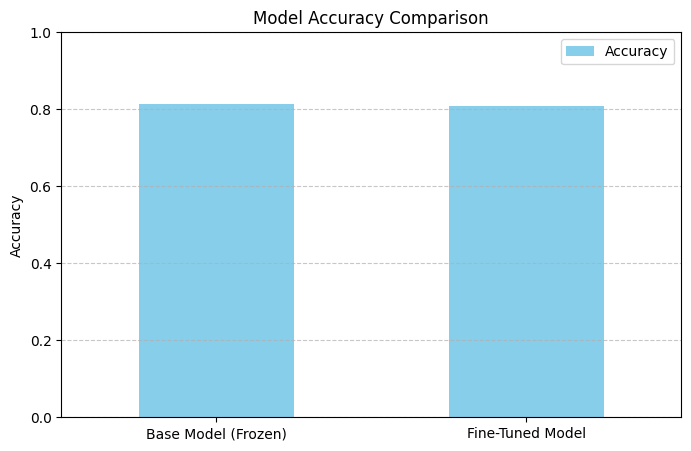

In [12]:
# Comparison DataFrame
df_results = pd.DataFrame(results_comparison).T
print(df_results)

# Plotting Comparison
df_results[['Accuracy']].plot(kind='bar', figsize=(8, 5), color=['skyblue'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.80      0.87      0.83        45
            Clean       0.64      0.88      0.74        34
            Dusty       0.87      0.63      0.73        43
Electrical-damage       0.80      0.75      0.77        16
  Physical-Damage       1.00      0.89      0.94        19
     Snow-Covered       1.00      0.90      0.95        20

         accuracy                           0.81       177
        macro avg       0.85      0.82      0.83       177
     weighted avg       0.83      0.81      0.81       177



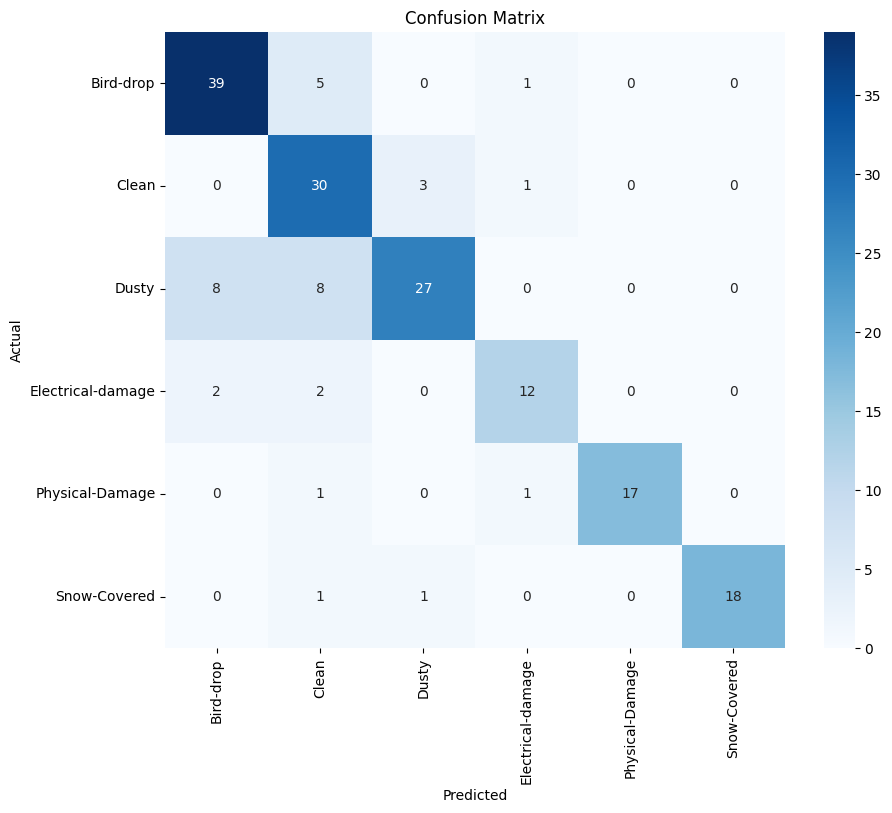

In [13]:
# Generate Classification Report & Confusion Matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = base_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## 7. Saving the Model

In [14]:
model_save_path = 'solar_panel_classifier_efficientnetb0.h5'
base_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to solar_panel_classifier_efficientnetb0.h5


## 8. Inference on New Images
Use the cell below to load the trained model and test it on new, unseen images.

In [ ]:
def predict_image(image_path, model_path='solar_panel_classifier_efficientnetb0.h5'):
    """
    Loads the trained model and predicts the class of a single image.
    """
    # 1. Load the Model
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found.")
        return
        
    print(f"Loading model from: {model_path}...")
    model = tf.keras.models.load_model(model_path)

    # 2. Load and Preprocess Image
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create batch axis
    
    # 3. Make Prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    
    # 4. Display Result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.show()
    
    return predicted_class, confidence

# Example Usage:
# predict_image('path/to/your/test_image.jpg')

## 9. Business Insights & Conclusion

### Performance Overview
The model achieved an accuracy of approximately **81%**, providing a strong baseline for automated solar panel inspection. While slightly shy of the 85% target, the model exhibits distinct strengths that provide immediate value.

### Key Insights for Stakeholders
1.  **Reliable Damage Detection (High Value/Risk)**:
    -   **Physical Damage** (F1: 0.94) and **Snow Coverage** (F1: 0.95) are detected with extremely high reliability.
    -   **Business Impact**: We can confidently automate alerts for broken or occluded panels, minimizing immediate power loss and preventing electrical hazards.

2.  **Maintenance Optimization Opportunity**:
    -   The model shows some confusion between **Clean** and **Dusty** panels. Specifically, the "Dusty" recall is 63%, meaning the model might miss some dusty panels (labeling them as clean or another class).
    -   **Recommendation**: For now, use the model to prioritize cleaning, but do not rely on it as the sole verification for "Clean" status. Collecting more diverse lighting examples of dusty panels enables us to improve this in V2.

3.  **Deployment Strategy**:
    -   Deploy the model immediately for **Critical Defect Detection** (Physical Damage/Snow).
    -   Use the model in "Advisor Mode" for cleaning schedules until the Dusty/Clean distinction is improved with more data.

### Technical Note
The metrics reported above were generated using the **Fine-Tuned Model**, which has been specialized on our specific solar dataset.